# MIE1624 Assignment 2: Classification 
## Zain Nasrullah (998892685)

The goal of this project is to build a model that can predict which income bracket an individual falls into using the UCI adult income dataset. As an additional layer of complexity, this target variable in this dataset contains 3 classes rather than the standard 2. 

In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pickle
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import BalancedBaggingClassifier 

In [2]:
# View which files I'll be working with
! dir 

 Volume in drive E is SSD Storage
 Volume Serial Number is EE67-6782

 Directory of E:\OneDrive - University of Toronto\Jupyter\MScAC\Data Analytics\Assignment 2

11/22/2017  03:27 PM    <DIR>          .
11/22/2017  03:27 PM    <DIR>          ..
11/22/2017  01:11 PM    <DIR>          .ipynb_checkpoints
11/19/2017  04:30 PM           198,512 Assignment 2.docx.pdf
11/22/2017  03:22 PM        19,682,558 clf_imbag.sav
11/22/2017  02:26 PM         4,410,945 clf_knn.sav
11/22/2017  02:14 PM             9,908 clf_lr.sav
11/22/2017  03:17 PM         4,717,418 clf_rf.sav
11/22/2017  02:50 PM         1,307,547 clf_svc.sav
11/19/2017  04:30 PM         1,316,744 income-testing.csv
11/19/2017  04:30 PM         2,631,857 income-training.csv
11/22/2017  03:23 PM         4,718,276 model.sav
11/22/2017  01:21 PM               659 README.md
11/22/2017  03:27 PM           378,630 ZainNasrullah998892685Assignment2Classification.ipynb
              11 File(s)     39,373,054 bytes
               3 Dir(s)  3

# Exploring the data

In [3]:
# Pull in the data and take a look at it
df = pd.read_csv('income-training.csv')
print(df.shape)
df.head()

(24421, 15)


,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


There are a total of 24421 rows of data with 15 features. The final feature, IncomeBracket, is the target variable for the classification task. Any features with missing values  will need to be investigated:

In [4]:
# Continuous variables
df.describe()

,Age,FinalWeight,EducationLvl,CapitalGain,CapitalLoss,HoursPerWeek
count,24421.000000,2.442100e+04,24421.000000,24421.000000,24421.00000,24421.000000
mean,38.635273,1.908781e+05,10.100078,1073.734900,90.72581,40.495352
std,13.658678,1.066108e+05,2.579953,7372.250508,410.42682,12.363606
min,17.000000,1.349200e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.182590e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783830e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.394090e+05,13.000000,0.000000,0.00000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.00000,99.000000


From the continuous feature summary above, it appears that none of the continuous variables are missing any data. However, we can take into consideration that the data seems to be on different scales. It will be best to normalize these if using them in a model. Moving on to the categorical features:

In [5]:
# Discrete variables
df.describe(include=['O'])

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Sex,NativeCountry,IncomeBracket
count,23037,24421,24421,23031,24421,24421,24421,24026,24421
unique,8,16,7,14,6,5,2,41,3
top,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<50K
freq,17002,7935,11279,3102,9920,20910,16357,21978,18433


From the categorical feature summary above, we observe that WorkClass, Occupation, and NativeCountry are missing some values.   

# Data Cleaning & Feature Engineering

Since this data seems to be survey or census data, there are a couple of possible reasons as to why there would be missing categorical values. For the Workplace and Occupation questions, I suspect that the majority of missing values stem from human interpretion of the question or possible answers. In this context, the responder probably felt that he or she didn't fall into any of the answer categories provided. It's also possible that the question, or provided options, were ambigious and thus the responder opted not to answer. For example, if one answer's Never-worked to the WorkClass question, there is no corresponding option in Occupation. If there is a little bit of ambiguity regarding what to say, it's easier just to leave this option blank if you don't have an answer that fits into the provided options. Given that all other values are filled out, I doubt the reason was something trivial like not feeling comfortable with answering the particular question or forgetting.  

The NativeCountry feature is also missing a few hundred responses. This, again, could be because the individual is from a country not listed as part of survey provided options. If this field was a fill in the blank instead of a choice, it's possible the individual wrote the response illegibly or misinterpreted the question causing the data to be omitted. For example, an individual may have thought they didn't need to answer this question as it was only directed at immigrants and not natives.   

Dealing with these missing values will be difficult. Simply using the mode here doesn't make the most sense as it could produce results which are entirely wrong. This will later impact our model of the target variable. After all, if the features themselves contain noise, it's possible that the model will not generalize well (i.e, garbage in garbage out). However, we can't drop these features as they're useful for understanding an individual's income bracket. Let's explore further:

In [6]:
print("WorkClass missing values:",df[(df['WorkClass'].isnull())].shape)
print("Occupation missing values:",df[(df['Occupation'].isnull())].shape )
print("NativeCountry missing values:",df[(df['NativeCountry'].isnull())].shape )

WorkClass missing values: (1384, 15)
Occupation missing values: (1390, 15)
NativeCountry missing values: (395, 15)


It seems that there may be overlap between the individuals who opted not to respond  to the WorkClass and Occupation categories:

In [7]:
print("Workclass & Occupation missing:", df[(df['WorkClass'].isnull()) & (df['Occupation'].isnull())].shape)

Workclass & Occupation missing: (1384, 15)


From the above, we see that there is overlap between not responding to WorkClass and Occupation. This further supports the theory that individuals didn't answer these two questions specifically because they didn't find that workplace answers were relevant to them. From the below, we see that there isn't much overlap with NativeCountry. This suggests that people who didn't respond to the country question did so for unrelated reasons.

In [8]:
print("Workclass & NativeCountry missing:", df[(df['WorkClass'].isnull()) & (df['NativeCountry'].isnull())].shape)
print("Occupation & Native missing:", df[(df['Occupation'].isnull()) & (df['NativeCountry'].isnull())].shape)

Workclass & NativeCountry missing: (18, 15)
Occupation & Native missing: (18, 15)


 Looking at the education levels may give us a better idea of why blanks were left:

In [9]:
df_nr = df[(df['WorkClass'].isnull()) | (df['Occupation'].isnull()) | (df['NativeCountry'].isnull())]
df_nr.groupby(["Education"])["Education"].count().sort_values(ascending = False)

Education
HS-grad         515
Some-college    468
Bachelors       209
11th             90
10th             79
Masters          71
7th-8th          66
Assoc-acdm       49
Assoc-voc        46
9th              40
12th             35
5th-6th          29
Doctorate        28
Prof-school      25
1st-4th          11
Preschool         6
Name: Education, dtype: int64

It seems that a good chunk of people that did not respond to questions are high school graduates, or only have some experience in college. If these are students (university), it would explain why they didn't have a meaningful way to answer the WorkClass and Occupation questions. When exploring by age, the youngest individual is observed to be 17 despite the highest level of education ranging from preschool to a PhD. This means that there are quite a few people in this survey that don't have a formal education:

In [10]:
df_nr.groupby(["Age"])["Age"].count().head(n=10)

Age
17    51
18    89
19    96
20    96
21    74
22    69
23    47
24    42
25    32
26    27
Name: Age, dtype: int64

In [11]:
df_nr.groupby(["IncomeBracket"])["IncomeBracket"].count().head(n=10)

IncomeBracket
50-100K     157
<50K       1532
>100K        78
Name: IncomeBracket, dtype: int64

The income bracket for the missing values is predominantly the lowest tier. This should be considered when filling in missing values. If we do choose to use the mode to fill NaNs, looking at the _top_ statistic in the following describes what value will be used for the mode in each category:

In [12]:
df.describe(include=['O'])

,WorkClass,Education,MaritalStatus,Occupation,Relationship,Race,Sex,NativeCountry,IncomeBracket
count,23037,24421,24421,23031,24421,24421,24421,24026,24421
unique,8,16,7,14,6,5,2,41,3
top,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<50K
freq,17002,7935,11279,3102,9920,20910,16357,21978,18433


Given the above, it's not really reasonable to always assume the mode. For example, it is unlikely for an individual to end up as a managerial executive without at least a high school education. This sort of assumption is unreasonable and will definitely bias the model because it's incorrect. Coming up with rules for imputing each group of missing values is a modelling problem on its own, and thus it makes more sense to drop the rows with unknown values or replace them with new categories representing a lack of knowledge. For this analysis, I will replace missing WorkClass and Occuption values with "Missing". Missing countries will be replaced by "Other". Perhaps these new categories can provide some insight as well. All other missing values (for future datasets) will be replaced by mode and mean for categorical and continuous variables respectively.  

In addition to resolving the issue of missing values, the clean function has two other responsibilities: 
- Feature Engineering
- Converting categorical variables to numerical   

Since some features contain a large number of unique categories (education/occupation/nativecountry), it's a good idea to clean them up for better interpretability. Furthermore, the majority of these features are not ordinal and thus we use simple label encoding but rather must use the one hot encoded vector form to represent them. The reason for this is that the label form assumes that there is some sort of structure / order to the label form. This provides additional incentive to perform significant data cleaning / feature engineering early on to ensure the data is in a reasonable form to work with. The full scope of this feature engineering will be described in the cell following the clean function.

In [13]:
def clean(df):
    # obtain data types and features in list format
    d_types = df.dtypes
    feature = df.columns
    
    # Deal with missing values
    df.loc[df["WorkClass"].isnull(), "WorkClass"] = "Missing"
    df.loc[df["Occupation"].isnull(), "Occupation"] = "Missing"
    df.loc[df["NativeCountry"].isnull(), "NativeCountry"] = "Other"   
    
    # Deal with missing values for all other columns
    for i, d_type in enumerate(d_types):
        if d_type == 'object':
            df[feature[i]].fillna(df[feature[i]].mode()[0], inplace= True)
        else:
            df[feature[i]].fillna(df[feature[i]].mean(axis = 0), inplace= True)
            
    # Feature Engineering
    # Reduce the number of categories in work class
    WorkClassMap = {'Private':'Private', 'Self-emp-not-inc': 'Self Employed', 'self-emp-inc': 'Self Employed',
                    'Federal-gov':'Government', 'Local-gov': 'Government', 'State-gov':'Government',
                    'Without-pay': 'Unemployed', 'Never-worked':'Unemployed', 'Missing':'Missing'}          
    df['WorkClass'] = df['WorkClass'].map(WorkClassMap)
    
    # Reduce the number of categorices in Marital Status
    MaritalStatusMap = {'Married-civ-spouse': 'Married', 'Married-spouse-absent': 'Married', 'Married-AF-spouse': 'Married'}
    df['MaritalStatus'] = df['MaritalStatus'].map(MaritalStatusMap)
    
    # Create new feature of net capital
    df['NetCapital'] = df['CapitalGain'] - df['CapitalLoss']
    
    # Represent in binary form
    df['is-Male?'] = np.where(df['Sex'] == 'Male', 1, 0)
    
    # Determine if individual has child or not and drop the rest of the relationship column
    df['Has Child'] = np.where(df['Relationship'] == 'Own-child', 1, 0)
    
    # Map Countries to Continents to reduce number of variables (loss resolution but gain interpretability)
    # Hong and South are assumed to be Hong Kong and South Korea respectively
    countryMap = {'United-States': 'North America', 'Outlying-US(Guam-USVI-etc)': 'North America', 'Mexico': 'North America',
       'El-Salvador': 'North America', 'Taiwan':'Asia', 'Haiti': 'North America', 'Cuba': 'North America', 'Philippines': 'Asia',
       'Puerto-Rico': 'North America', 'Japan': 'Asia', 'Thailand': 'Asia', 'Hungary':'Europe', 'France':'Europe', 'Columbia': 'South America',
       'India': 'Asia', 'Jamaica': 'North America', 'Germany': 'Europe', 'Peru':'South America', 'Canada': 'North America', 'Hong': 'Asia', 'Italy':'Europe',
       'Honduras': 'North America', 'Poland': 'Europe', 'Ecuador':'South America', 'Ireland':'Europe', 'Cambodia': 'Asia', 'Guatemala': 'North America',
       'Dominican-Republic':'North America', 'Greece':'Europe', 'Nicaragua':'North America', 'Iran': 'Asia', 'Vietnam':'Asia',
       'Trinadad&Tobago': 'South America', 'China':'Asia', 'South':'Asia', 'England':'Europe', 'Yugoslavia':'Europe',
       'Portugal': 'Europe', 'Laos':'Asia', 'Scotland':'Europe', 'Holand-Netherlands':'Europe', 'Other':'Other'}
    df['Continent'] = df['NativeCountry'].map(countryMap)
    
    # Drop the following columns as they've been transformed
    # Education is dropped because EducationLvl represents the same information in a neater form
    df.drop(['Education', 'Relationship', 'CapitalGain', 'CapitalLoss', 'NativeCountry', 'Sex'], axis = 1, inplace=True)
    
    # Label encoding as one-hot encoded vectors when data is not ordinal
    cat_features = list(df.select_dtypes(['object']).columns)
    cat_features.remove('IncomeBracket')
    df_encoded = pd.get_dummies(df, prefix = cat_features, columns = cat_features)
    incomeMap = {'<50K':0, '50-100K':1, '>100K':2}
    df_encoded["IncomeBracket"] = df_encoded['IncomeBracket'].map(incomeMap)
    
    # ensure income bracket is the first column in the dataframe
    target = df_encoded['IncomeBracket']
    df_encoded.drop(labels=['IncomeBracket'], axis=1,inplace = True)
    df_encoded.insert(0, 'IncomeBracket', target)
       
    return df_encoded

### List of Modified Features
- WorkClass is reduced into 4 categories {Private, Government, Unemployed, Missing}
- Education is dropped and Educationlvl is maintained
- MartialStatus is reduced to 4 categories {Married, Never-married, Separated, Widowed}
- Sex is converted to a binary label {0: female, 1: male}
- Whether the individual has a child is extracted from Own-child. A lot of the other categories in here are redundant or irrelvant to income bracket. This column will be dropped. 
- CapitalGain and CapitalLoss are combined to create the new feature NetCapital
- Countries are mapped to their continent {North America, South Americca, Europe, Asia}
- Education, Relationship, CapitalGain, CapitalLoss, NativeCountry, and Sex are dropped because they are all replaced by new features.

### Encoding
Only IncomeBracket is encoded into an ordinal class label because the income brackets are ordered, while every other categorical feature is converted into its dummy variable form.

The function defined in the cell above fills in missing values and encodes the data. It is applied to a copy of the dataframe below.

In [14]:
df_clean = df.copy(deep=True)
df_clean = clean(df_clean)
df_clean.head()

,IncomeBracket,Age,FinalWeight,EducationLvl,HoursPerWeek,NetCapital,is-Male?,Has Child,WorkClass_Government,WorkClass_Missing,...,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Continent_Asia,Continent_Europe,Continent_North America,Continent_Other,Continent_South America
0,0,42,179151,10,40,0,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
1,0,28,68021,10,30,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,1,24,233499,10,40,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,32,168782,5,32,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,55,105582,14,50,2228,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0


We can do a quick verification to ensure that each feature contains 24421 rows of data:

In [15]:
df_clean.describe()

,IncomeBracket,Age,FinalWeight,EducationLvl,HoursPerWeek,NetCapital,is-Male?,Has Child,WorkClass_Government,WorkClass_Missing,...,Race_Amer-Indian-Eskimo,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Continent_Asia,Continent_Europe,Continent_North America,Continent_Other,Continent_South America
count,24421.000000,24421.000000,2.442100e+04,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,...,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000,24421.000000
mean,0.326850,38.635273,1.908781e+05,10.100078,40.495352,983.009091,0.669792,0.153393,0.133655,0.056673,...,0.009377,0.030916,0.095696,0.007780,0.856230,0.022317,0.015397,0.942304,0.016175,0.003808
std,0.619142,13.658678,1.066108e+05,2.579953,12.363606,7396.848426,0.470297,0.360373,0.340289,0.231221,...,0.096383,0.173094,0.294180,0.087863,0.350863,0.147715,0.123127,0.233173,0.126149,0.061594
min,0.000000,17.000000,1.349200e+04,1.000000,1.000000,-4356.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,1.182590e+05,9.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,37.000000,1.783830e+05,10.000000,40.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,48.000000,2.394090e+05,13.000000,45.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,2.000000,90.000000,1.490400e+06,16.000000,99.000000,99999.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis

For the prelimary visual data analysis, I will use the uncleaned dataframe to take advantage of the original format of the data which is better for human interpretation. Furthermore, it gives us a sense of what trends are in the data prior to manipulation. As a reminder, we are working with the following features:

In [16]:
df.head()

,Age,WorkClass,FinalWeight,Education,EducationLvl,MaritalStatus,Occupation,Relationship,Race,Sex,CapitalGain,CapitalLoss,HoursPerWeek,NativeCountry,IncomeBracket
0,42,State-gov,179151,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,United-States,<50K
1,28,Private,68021,Some-college,10,Never-married,Other-service,Not-in-family,White,Female,0,0,30,United-States,<50K
2,24,Private,233499,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,50-100K
3,32,Self-emp-not-inc,168782,9th,5,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,32,United-States,<50K
4,55,Self-emp-not-inc,105582,Masters,14,Married-civ-spouse,Sales,Husband,White,Male,2228,0,50,United-States,<50K


First, let's visualize how the IncomeBracket varies against Age:

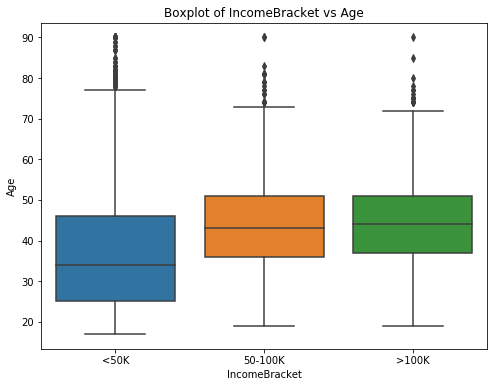

In [17]:
figure = plt.figure(figsize = (8,6))
sns.boxplot(x="IncomeBracket", y = "Age", data = df);
plt.ylabel("Age");
plt.title("Boxplot of IncomeBracket vs Age");

From the above, it seems that the median age associated with the higher income brackets is about 10 years older than than the less than $50K bracket. Therefore, we know that age does seem to have some impact on predicting IncomeBracket and thus it should probably be maintained in our model.   
   
Next, let's take a look at the number of males and females in each income bracket:

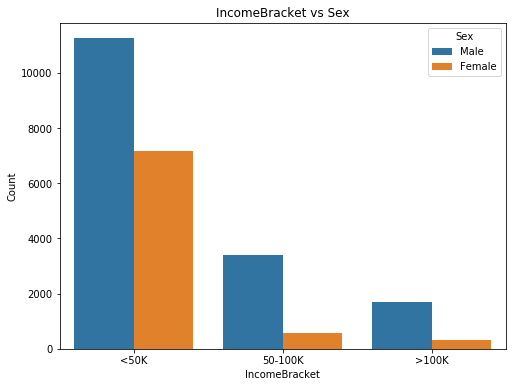

In [18]:
figure = plt.figure(figsize = (8,6))
sns.countplot(x="IncomeBracket", hue = "Sex", data = df);
plt.ylabel("Count");
plt.title("IncomeBracket vs Sex");

From the above, it seems that our survey contains far more males than females. However, what's interesting to note is that in the lower income bracket (<$50K), the proportion of males to females is about 2:1. However, in the higher income brackets, there are far fewer females and this proportion of males to females changes to about 8:1. This means that there are far fewer women in high income brackets than the low income bracket. This suggests that there is a relationship between Sex and IncomeBracket.   

Finally, let's take a look at IncomeBracket vs EducationLvl:

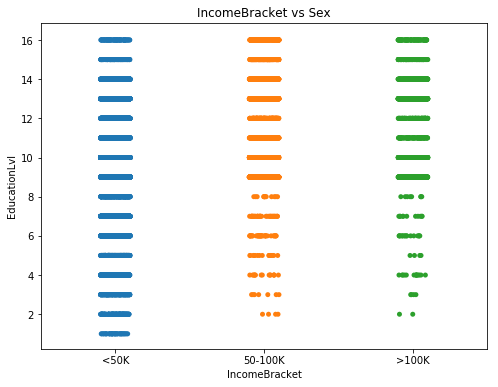

In [19]:
figure = plt.figure(figsize = (8,6))
sns.stripplot(x="IncomeBracket", y="EducationLvl", data=df, jitter=True);
c = df_clean.corr()
plt.title("IncomeBracket vs Sex");

In the low income bracket, there are a large number of people in each education bracket. As the income bracket increases, the number of people at the lower EducationLvls begins to fall off. This suggests that, in general, people within the high income bracket have high levels of education. The opposite of this statement, however, is not true. Possessing high education does not necessitate that an individual will belong in a higher income bracket. In the low income bracket, we see that every education level is well represented. 

To investigate feature importance, let's calculate correlation using both the original dataframe and the cleaned datafarmes:

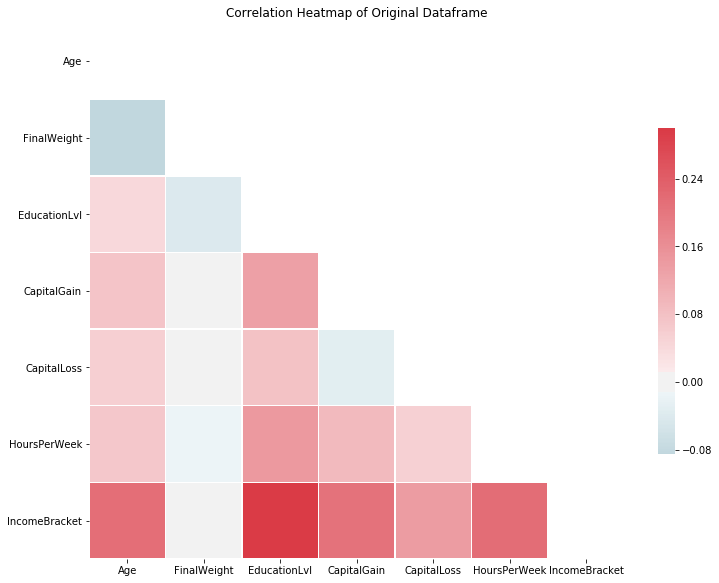

In [20]:
df_corr = df.copy(deep=True);
incomeMap = {'<50K':0, '50-100K':1, '>100K':2};
df_corr["IncomeBracket"] = df_corr['IncomeBracket'].map(incomeMap);
c = df_corr.corr();

# Create mask
mask = np.zeros_like(c, dtype=np.bool);
mask[np.triu_indices_from(mask)] = True;

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True);

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

plt.title('Correlation Heatmap of Original Dataframe');
plt.yticks(rotation=0);

From the last row in the above plot, it seems that IncomeBracket (final row) is related to most of the numerical features in the original dataframe except for the FinalWeight. However, one should take note that these correlation coefficients are not very high with the maximum value being in the 0.2-0.3 range.    

In the cleaned dataset:

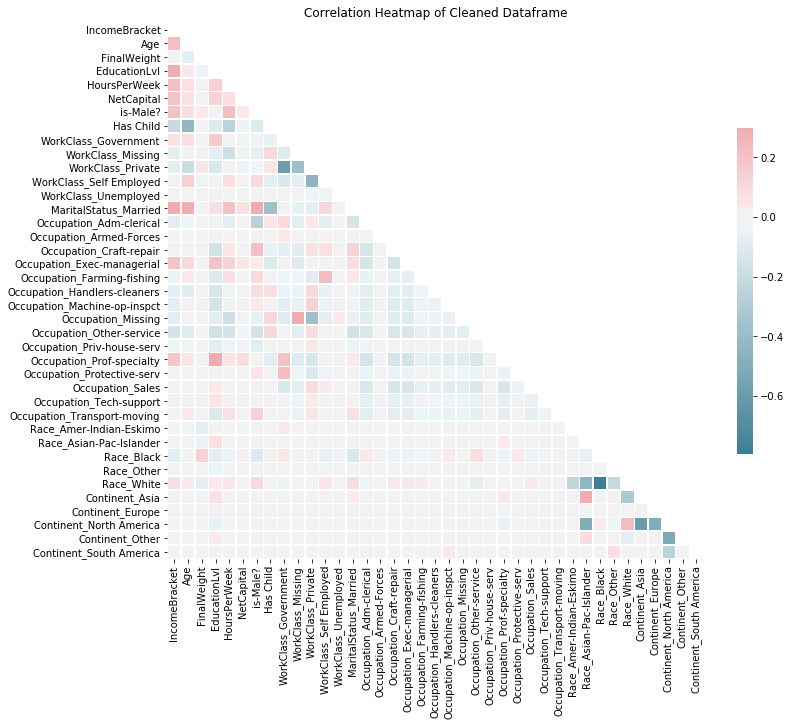

In [21]:
c = df_clean.corr()

# Create mask
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap of Cleaned Dataframe');

From the first column in the above, we also see that IncomeBracket is reasonably correlated (both positively and negatively) with about 10 or so of the cleaned up features. These include Age, Education Lvl, HoursPerWeek, NetCapital, isMale, Has Child, WorkClass_Government, MaritalStatus_Married, Occupation_Exec-managerial, Occupation_Other-service, Occupation_Prof-specialty and Race_white. It's interesting that male, white and married men working as executives seem to be in the largest income bracket; this is in line with the usual stereotype. Looking just at the correlation with the target variable:

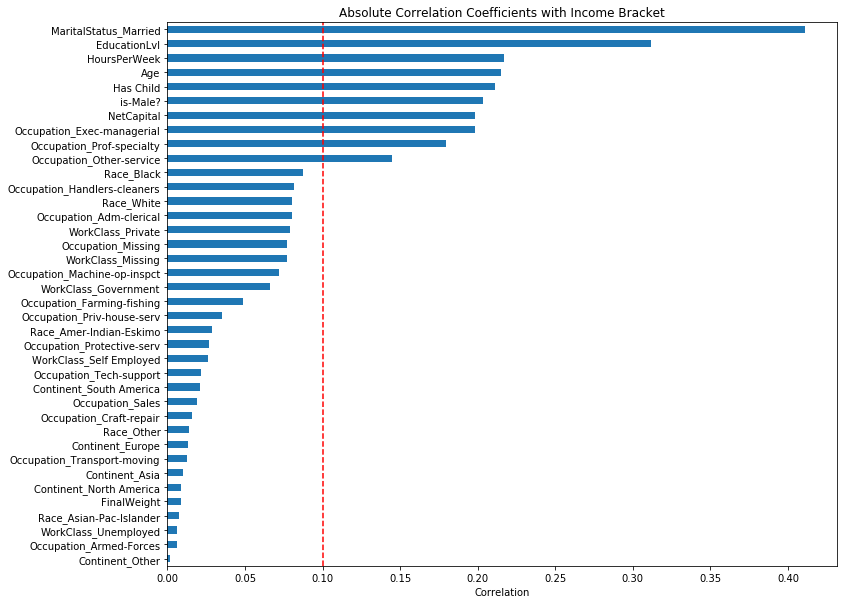

In [22]:
incomeCorr = c['IncomeBracket']
figure = plt.figure(figsize=(12,10))
(abs(incomeCorr[abs(incomeCorr).argsort()[::-1]][1:])).sort_values(ascending = True).plot(kind='barh')
plt.axvline(x=0.10, c = 'r', ls = '--')
plt.title('Absolute Correlation Coefficients with Income Bracket')
plt.xlabel('Correlation');

In [23]:
incomeCorr[abs(incomeCorr).argsort()[::-1]][1:]

MaritalStatus_Married           0.411130
EducationLvl                    0.312047
HoursPerWeek                    0.216781
Age                             0.215345
Has Child                      -0.211132
is-Male?                        0.203177
NetCapital                      0.198358
Occupation_Exec-managerial      0.198241
Occupation_Prof-specialty       0.179840
Occupation_Other-service       -0.144542
Race_Black                     -0.087199
Occupation_Handlers-cleaners   -0.081433
Race_White                      0.080600
Occupation_Adm-clerical        -0.080128
WorkClass_Private              -0.078824
Occupation_Missing             -0.077168
WorkClass_Missing              -0.076764
Occupation_Machine-op-inspct   -0.071627
WorkClass_Government            0.066310
Occupation_Farming-fishing     -0.048838
Occupation_Priv-house-serv     -0.035347
Race_Amer-Indian-Eskimo        -0.028717
Occupation_Protective-serv      0.026735
WorkClass_Self Employed         0.026040
Occupation_Tech-

From the correlation plots and list above, we observe that most features have very little impact on the target variable. Consequently, I've chosen to only take features with a absolute correlation coefficients greater than 0.1 as part of my feature set. This is reasonable because the other variables add very little information at the cost of a huge increase in dimensionality.  

In [24]:
#feature_set = incomeCorr[abs(incomeCorr).argsort()[::-1]][1:12].index
feature_set = incomeCorr.index[(abs(incomeCorr) > 0.1)][1:]
print("In total, the model will be using", len(feature_set), "features.")

In total, the model will be using 10 features.


# Model Implementation & Tuning

As a first step, let's preparing the data for preprocessing and set up a helper function to build generic models. The models specified below are:
- Logistic Regression Classifier
- K\-Nearest Neighbours Classifier
- Support Vector Classifier
- Random Forest Classifier

I'll discuss each model, why it was implemented and its performance in the subsequent subsections. However, I chose these models because I expect each one to improve upon the previous in some way.

In [25]:
# Grab the test data and target variables
X = np.array(df_clean[feature_set])
Y = np.array(df_clean["IncomeBracket"])
X, Y = shuffle(X, Y)

# Grab the test data that will be used to evaluate each model
df_test = clean(pd.read_csv('income-testing.csv'))
X_test = df_test[feature_set]
Y_test = df_test['IncomeBracket']

# Define different types of models
def getModel(modelName):
    if modelName == 'knn':
        model = KNeighborsClassifier()
    elif modelName == 'lr':
        model = LogisticRegression()
    elif modelName == 'svc':
        model = SVC()
    elif modelName == 'rf':
        model = RandomForestClassifier()
    else:
        print ("Invalid Model")
    return model

Now, for each model, I will perform a grid search with 10-fold cross-validation across various model parameters. The output will each cell block will summarize all of the relevant statistics for this fit including:
- Mean accuracy and standard deviation across folds for each input parameter
- Best parameters found their and corresonding fold test accuracy
- A classification report (Precision, Recall, F1-Score) found via applying the optimal parameter settings on the test set

I am reporting the mean scores across folds because this prevents the results from becoming unnecessarily verbose. The mean and standard deviation are enough to get a good idea of how the scores are changing across folds. It is possible to view the actual scores within each fold and set of hyperparameters using clf.cv\_results\_. 

I will use Accuracy, Recall, Precision, and the F1 Score to evaluate each model on the test set using the optimal parameters.
- Recall describes the number of true positives over the sum of true positives and false positives. Intuitively, this describes how often the model was correct when it predicted the positive class.
- Precision describes the number of true positives over the sum of true positives and false negatives. Intuitively, this describes how well the model predicted when the true class was in fact the positive class.  
- The F1 score is the harmonic mean of Precision and Recall. In other words, it can combine both scores into a single metric.
- Accuracy describes how often the model was correct. 

The benefit of using these methods is that we can observe how well the model is performing for each class and on average rather than just looking at a singular accuracy score. The weakness of using these metrics is that they do not account for true negatives; however, it is an improvement over simply looking at accuracy. 

In the grid search, the weighted (by support) f1 score is used to keep track of the best overall performance instead of accuracy. This is done because the classes are not balanced (there are 18433 samples in the less than 50K category, 3994 in the 50K-100K and 1994 in the greater than 100K category) and thus accuracy can be very misleading. 

In [26]:
np.unique(Y, return_counts = True)

(array([0, 1, 2], dtype=int64), array([18433,  3994,  1994], dtype=int64))

### Model 1: Logistic Regression

Logistic Regression is a linear classifier that models the discriminative probability of a class given data using a sigmoidal activation function. This means that the output of logistic regression can be interpreted as a probability; when this probability exceeds a certain threshold (by default 0.5 in SKlearn and not modifiable without playing with the class weights), we can use this information to make a decision. By default, logistic regression is applied to binary class problems. Extending it to a multi-class problems involves using the OvR methodology or working with the softmax implementation and cross-entropy loss instead.  

I picked this model as first because it's the most basic and widely used model in industry. It's often the go-to choice for a preliminary test. Its pros are that it's fast and doesn't have many hyper parameters to tune and easy to interpret. Its cons are that it's a linear classifier which means that it cannot model complex decision boundaries. It will fail when the classes aren't linearly separable. Furthermore, the common OvR methodology has limitations because it's possible for there to exist a region in space where the model belongs to more than one class thus leading to ambiguity.  

In [27]:
# suppressing warnings here because of division by zero in F1 score calculation (see cell below for full explanation)
warnings.filterwarnings(action='ignore')

# Grid search with cross validation commented out
'''
model = getModel('lr')
parameters = [{'penalty':['l1','l2'], 'C': [1, 10, 100], 'class_weight':['balanced',None]}]
clf = GridSearchCV(model, parameters, cv = 10);
clf.fit(X, Y);
clf_lr = clf
with open("clf_lr.sav", "wb") as f:
    pickle.dump(clf_lr, f)
'''
with open("clf_lr.sav", "rb") as f:
    clf = pickle.load(f)
    
print("Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("MSAF: %0.5f, STD: %0.05f for %r"
          % (mean, std,params))
    
print()
print('Best Params:', clf.best_params_)
print("Best Mean Train Score Across Folds:", clf.best_score_)
print()

# evaluate on test set
predictions = clf.predict(X_test)
ACC = accuracy_score(Y_test,predictions)*100
print('Model accuracy on test set: {}'.format(round(ACC,2)))
print("Applying optimal settings to the test set yields:")
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))


warnings.filterwarnings(action='default')

Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:

MSAF: 0.77765, STD: 0.00900 for {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1'}
MSAF: 0.77769, STD: 0.00906 for {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2'}
MSAF: 0.79464, STD: 0.00638 for {'C': 1, 'class_weight': None, 'penalty': 'l1'}
MSAF: 0.79440, STD: 0.00579 for {'C': 1, 'class_weight': None, 'penalty': 'l2'}
MSAF: 0.77786, STD: 0.00899 for {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1'}
MSAF: 0.77773, STD: 0.00911 for {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2'}
MSAF: 0.79452, STD: 0.00653 for {'C': 10, 'class_weight': None, 'penalty': 'l1'}
MSAF: 0.79452, STD: 0.00591 for {'C': 10, 'class_weight': None, 'penalty': 'l2'}
MSAF: 0.77781, STD: 0.00848 for {'C': 100, 'class_weight': 'balanced', 'penalty': 'l1'}
MSAF: 0.77761, STD: 0.00924 for {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}
MSAF: 0.79489, STD: 0.00624 for {'C': 100, 'class_weight': None, 'penalty': '

The logistic regression model appears to be performing well with reasonable accuracy on the train (~79%) set across folds and the test(~78%) set. **However**, but if we look closely at classification report on the test set, you'll see that the model is consistently failing to identify class 2 (the >100K class) and struggling with class 1 (50K-100K). This is probably because of where the decision boundary is placed using OvR, the data not being linearly separable, and the overall class imbalance. Clearly, this model is not actually doing a good job; it only predicts class 0 well and the net high accuracy is a direct result of the imbalanced classes. 

### Model 2: KNN

The K-Nearest Neighbours is a non-parametric model in that it scales with the size of the train data. This model computes the distance between each test point and all points in the train set; the k closest points via distance are chosen as its k nearest neighbors. The dominant / most frequent class in the k-nearest neighbors is chosen as the assigned class. 

As a result of using this 'distance' based technique, it creates complex piecewise linear decision boundaries that can work well on non-linear data compared to logistic regression. I selected this as the second method for this reason. The pros of kNN are its non-linear flexibility and realistically only needing to tune the hyperparameter k. However, since this measure relies heavily on distance, it's important to ensure the distance metric used makes sense given the data. In this case, we have a lot of categorical variables encoded as one-hot vectors which may be negatively impacting our results as they are not always the easiest to work with using kNN. Furthermore, KNN is computationally expensive at test time as this is where it actually calculates distances; the fit method only loads the train data into memory which must be held (thus introducing a memory requirement). 

In [28]:
# Grid search with cross validation commented out
'''
model = getModel('knn')
parameters = {'n_neighbors': list(range(1,30))}
clf = GridSearchCV(model, parameters, cv = 10);
clf.fit(X, Y);
clf_knn = clf
with open("clf_knn.sav", "wb") as f:
    pickle.dump(clf_knn, f)'''

with open("clf_knn.sav", "rb") as f:
    clf = pickle.load(f)

print("Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("MSAF: %0.5f, STD: %0.05f for %r"
          % (mean, std,params))
print()
print('Best Params:', clf.best_params_)
print("Best Mean Train Score Across Folds:", clf.best_score_)
print()

# evaluate on test set
predictions = clf.predict(X_test)
ACC = accuracy_score(Y_test,predictions)*100
print('Model accuracy on test set: {}'.format(round(ACC,2)))
print("Applying optimal settings to the test set yields:")
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))

Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:

MSAF: 0.74641, STD: 0.00970 for {'n_neighbors': 1}
MSAF: 0.78977, STD: 0.00317 for {'n_neighbors': 2}
MSAF: 0.77736, STD: 0.00585 for {'n_neighbors': 3}
MSAF: 0.79026, STD: 0.00486 for {'n_neighbors': 4}
MSAF: 0.78932, STD: 0.00400 for {'n_neighbors': 5}
MSAF: 0.79563, STD: 0.00148 for {'n_neighbors': 6}
MSAF: 0.79468, STD: 0.00249 for {'n_neighbors': 7}
MSAF: 0.80038, STD: 0.00192 for {'n_neighbors': 8}
MSAF: 0.79812, STD: 0.00264 for {'n_neighbors': 9}
MSAF: 0.79923, STD: 0.00404 for {'n_neighbors': 10}
MSAF: 0.79841, STD: 0.00260 for {'n_neighbors': 11}
MSAF: 0.80189, STD: 0.00291 for {'n_neighbors': 12}
MSAF: 0.79960, STD: 0.00341 for {'n_neighbors': 13}
MSAF: 0.80251, STD: 0.00355 for {'n_neighbors': 14}
MSAF: 0.80247, STD: 0.00297 for {'n_neighbors': 15}
MSAF: 0.80283, STD: 0.00343 for {'n_neighbors': 16}
MSAF: 0.80279, STD: 0.00324 for {'n_neighbors': 17}
MSAF: 0.80234, STD: 0.00410 for {'n_neighbors'

The mean score across folds is slightly higher for kNN at around 80% with the optimal k, but the main improvement is that it's now barely correctly classifying a few of class 2 samples in the test set. The test accuracy overall is better than logistic regression but the model is still not performing well. An underlying assumption behind kNN is that the data is exists in high dimensional space such that each point's nearest neighbors are representative of the correct class; when we're dealing with highly unbalanced data, this is often not the case. Furthmore, we've got quite a few dummy variables in this model as well that do not work well with distance based approaches such as kNN if we insist on using the same feature set. Overall, kNN offers an improvement over logistic regression but is also not performing well based on its Precision, Recall and F1 scores.

### Model 3: Support Vector Classifier (with RBF Kernel)

The SVM model with an RBF Kernel is capable of producing non-linear decision boundaries and is quite powerful. This particular classifier tries to maximize the distance between support vectors and the decision boundary to come up with an optimal solution. The support vectors are the closest points  to the decision boundary / separating hyperplane between the data. Since this requires solving a quadratic optimization problem, SVM can be quite slow. The kernel is basically a trick that can be applied to any linear model (the base SVM is a linear classifier) which transforms the data into some high-dimensional space described by a kernel function. In this new space, it is possible for a better decision boundary to exist. The RBF kernel is a popular kernel as it generally performs well with a variety of tasks. 

I chose this method because it builds upon logistic regression by being able to model non-linear decision boundaries without the weakness of kNN's distance based underlying assumption. 

Therefore, the pros of this method are that it's flexible in terms of creating decision boundaries and can even find boundaries where they don't ordinarily exist in the original feature space. However, the major con is that the technique is computationally expense. 

In [29]:
# Grid search with cross validation commented out
'''
model = getModel('svc')
parameters = {'kernel':['rbf'], 'C':[1, 10]}
clf = GridSearchCV(model, parameters, cv = 10);
clf.fit(X, Y);
clf_svc = clf
with open("clf_svc.sav", "wb") as f:
    pickle.dump(clf_svc, f)
'''
with open("clf_svc.sav", "rb") as f:
    clf = pickle.load(f)

print("Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("MSAF: %0.5f, STD: %0.05f for %r"
          % (mean, std,params))
print()
print('Best Params:', clf.best_params_)
print("Best Mean Train Score Across Folds:", clf.best_score_)
print()

# evaluate on test set
predictions = clf.predict(X_test)
ACC = accuracy_score(Y_test,predictions)*100
print('Model accuracy on test set: {}'.format(round(ACC,2)))
print("Applying optimal settings to the test set yields:")
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))

Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:

MSAF: 0.79440, STD: 0.00421 for {'C': 1, 'kernel': 'rbf'}
MSAF: 0.78273, STD: 0.00632 for {'C': 10, 'kernel': 'rbf'}

Best Params: {'C': 1, 'kernel': 'rbf'}
Best Mean Train Score Across Folds: 0.794398263789

Model accuracy on test set: 78.4
Applying optimal settings to the test set yields:
             precision    recall  f1-score   support

          0       0.82      0.97      0.89      9143
          1       0.53      0.33      0.40      1983
          2       0.28      0.03      0.05      1085

avg / total       0.72      0.78      0.74     12211


Confusion Matrix:
[[8896  232   15]
 [1266  645   72]
 [ 708  344   33]]


The SVM models performs comparably to the other classifiers. It, like kNN, is able to predict some of the class 2 samples unlike logistic regression. The mean accuracy across folds however is worse than kNN. This means that projecting the data into higher dimensional space using the RBF kernel didn't help increase class discriminability. 

### Model 4: Random Forest Classifier

The Random Forest Classifier is an ensemble method. Ensemble methods average the results of many weak classifiers with low bias and high variance to make predictions with low bias and variance. This is because when many models of high variance are averaged out, the result approaches an optimal predictor. In the Random Forest specifically, we use many decision trees with very low bias (generally we don't set a maximum depth) and then combine their predictions to get the final result. The randomized portion comes from the fact that the model fits these decision trees on random sub-samples of the data. This overall reduces overfitting and leads to improved predictive accuracy. 

I picked this method for the final one because I expected an ensemble classifier to outperform any individual classifier. We shall see if that's actually the case. 

The pros of this method are that it generally has great predictive accuracy and is fairly efficient compared to other more sophisticated methods used in deep learning. However, the weaknesses are that the model can overfit on the train data quite easily (especially compared to other models) and since it is an ensemble, it is difficult to interpret. 

In [30]:
# Grid search with cross validation commented out
'''
model = getModel('rf')
parameters = {'n_estimators': [10, 50, 100], 'max_depth':[None, 3, 7, 10, 15],
              'min_samples_split':[2,10,20,50], 'min_samples_leaf':[1,10,50,100,500] }
clf = GridSearchCV(model, parameters, cv = 10);
clf.fit(X, Y);
clf_rf = clf
with open("clf_rf.sav", "wb") as f:
    pickle.dump(clf_rf, f)
''' 
with open("clf_rf.sav", "rb") as f:
    clf = pickle.load(f)

# Grid search with cross validation
print("Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("MSAF: %0.5f, STD: %0.05f for %r"
          % (mean, std,params))
print()
print('Best Params:', clf.best_params_)
print("Best Mean Train Score Across Folds:", clf.best_score_)
print()

# evaluate on test set
predictions = clf.predict(X_test)
ACC = accuracy_score(Y_test,predictions)*100
print('Model accuracy on test set: {}'.format(round(ACC,2)))
print("Applying optimal settings to the test set yields:")
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))

Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:

MSAF: 0.77978, STD: 0.00663 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
MSAF: 0.78048, STD: 0.00479 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSAF: 0.78215, STD: 0.00547 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MSAF: 0.79620, STD: 0.00594 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}
MSAF: 0.79772, STD: 0.00558 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
MSAF: 0.79882, STD: 0.00551 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
MSAF: 0.80152, STD: 0.00532 for {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 10}
MSAF: 0.80447, STD: 0.00426 for {'max_depth': None, 'min_samples_leaf': 1, 'min_sa

             precision    recall  f1-score   support

          0       0.85      0.97      0.90      9143
          1       0.54      0.48      0.51      1983
          2       0.26      0.01      0.01      1085

avg / total       0.75      0.80      0.76     12211


Confusion Matrix:
[[8837  306    0]
 [1014  952   17]
 [ 578  501    6]]


**Note**: Scroll down to the bottom of the above output to see the summary. 

In terms of accuracy, we see that the random forest method performed the best generalizing with an 80.27% score on the test set and an 81% mean accuracy across folds in the cross validation. However, in terms of predicting class 2, it performed worse than knn and svm w/ rbf only doing slightly better than logistic regression. We can see this in the confusion matrix and F1 scores.

# Discussion

Overall, all of models perform poorly where it matters. While they all do a great job on classifying class 0, they struggle with classes 1 and 2. High accuracy scores are solely due to the unbalanced nature of the dataset. The original dataset hosted on the UCI site only contained two classes, less than \$50K and greater than \$50K. The dataset we're working with has another sub-division in the target variable adding complexity. In terms of accuracy, both kNN and Random Forest perform very well but when one looks at the confusion matrix or weighted F1 scores by class, it is clear that none of these models are practical for real-world usage. It's difficult in this situation to identify one model as the best performing model. Furthermore, the feature engineering performed prior can have a major impact on performance and may result in some models performing better than others. In terms of a best model, I would suggest Random Forest simply because it scored the highest overall accuracy and thus would perform best if tested against this metric; even if it isn't a good measure of actual performance.

Practically speaking, a potential approach to resolve this issue would be to manually train an ensemble of classifiers by undersampling the majority class. I tried doing this in the example below which resulted in worse accuracy, though it did perform much better in terms of identifying class 2.

### Bonus Model 5: Imbalanced Bagging Classifer
This model uses decision trees (or forests) as its weak classifiers and undersamples the majority class prior to training so the dataset is more balanced. I expected this to lead to better accuracy but instead it just lead to better general discriminability of class 2.

In [31]:
from imblearn.ensemble import BalancedBaggingClassifier 

# Grid search with cross validation commented out
'''
model = BalancedBaggingClassifier()
parameters = {'n_estimators': [20,50,100], 'ratio':['majority', 'not minority', 'all'], 'replacement':[True, False]}
clf = GridSearchCV(model, parameters, cv = 10);
clf.fit(X, Y);
clf_imbag = clf
with open("clf_imbag.sav", "wb") as f:
    pickle.dump(clf_imbag, f)
'''
with open("clf_imbag.sav", "rb") as f:
    clf = pickle.load(f)

# Grid search with cross validation
print("Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:\n")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("MSAF: %0.5f, STD: %0.05f for %r"
          % (mean, std,params))
print()
print('Best Params:', clf.best_params_)
print("Best Mean Train Score Across Folds:", clf.best_score_)
print()

# evaluate on test set
predictions = clf.predict(X_test)
ACC = accuracy_score(Y_test,predictions)*100
print('Model accuracy on test set: {}'.format(round(ACC,2)))
print("Applying optimal settings to the test set yields:")
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print()
print('Confusion Matrix:')
print(confusion_matrix(Y_test, Y_pred))

Mean Score Across Folds (MSAF) & Standard Deviation (STD) for each parameter:

MSAF: 0.63089, STD: 0.00787 for {'n_estimators': 20, 'ratio': 'majority', 'replacement': True}
MSAF: 0.63605, STD: 0.00666 for {'n_estimators': 20, 'ratio': 'majority', 'replacement': False}
MSAF: 0.66070, STD: 0.00964 for {'n_estimators': 20, 'ratio': 'not minority', 'replacement': True}
MSAF: 0.66226, STD: 0.00871 for {'n_estimators': 20, 'ratio': 'not minority', 'replacement': False}
MSAF: 0.69649, STD: 0.00954 for {'n_estimators': 20, 'ratio': 'all', 'replacement': True}
MSAF: 0.66328, STD: 0.00808 for {'n_estimators': 20, 'ratio': 'all', 'replacement': False}
MSAF: 0.63249, STD: 0.00659 for {'n_estimators': 50, 'ratio': 'majority', 'replacement': True}
MSAF: 0.63810, STD: 0.00863 for {'n_estimators': 50, 'ratio': 'majority', 'replacement': False}
MSAF: 0.66246, STD: 0.00649 for {'n_estimators': 50, 'ratio': 'not minority', 'replacement': True}
MSAF: 0.66312, STD: 0.00764 for {'n_estimators': 50, 'ratio'

We can see from the above that, although this model looks like it scores the lowest mean accuracies and F1 scores, it's actually doing a better job of predicting class 2 than any of the other models via the class specific F1-score and confusion matrix.

With that said, lets proceed using the Random Forest Classifier simply because it yields the best accuracy and it seems that the alternate test set will only be measured against accuracy. 

In [32]:
# Save the best model

best_model = "clf_rf.sav"
with open(best_model, "rb") as f:
    clf = pickle.load(f)
    
with open("model.sav", "wb") as f:
    pickle.dump(clf, f)

# Testing Against Alternative

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

use_scaler  = False

# load the optimal model
with open("model.sav", "rb") as f:
    model = pickle.load(f)

# load all the datasets
trainDF = clean(pd.read_csv('income-training.csv'))
testDF = clean(pd.read_csv('income-testing.csv'))
newtestDF = clean(pd.read_csv('income-testing-2.csv'))

# Load the train set
X_train = trainDF[feature_set]
y_train = trainDF['IncomeBracket']

# load the test set
X_test = testDF[feature_set]
y_test = testDF['IncomeBracket']

# load the alternative set
X_test_2 = newtestDF[feature_set]
y_test_2 = newtestDF['IncomeBracket']

if use_scaler:
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

# score the model
predictions = model.predict(X_test_2)
ACC = accuracy_score(y_test_2,predictions)*100
print('Model  performance  on test  set:  {}'.format(round(ACC,2)))
print()
print(classification_report(y_test_2, predictions))